# Definição do Problema
Nosso cliente possui um conjunto de dados de diversos e-mails com mensagens classificadas de vários tipos. Atualmente nosso cliente possui um time de 10 pessoas apenas para ler essas mensagens e separá-las por tópico. 

A operação cresceu e agora isso é um problema. Será que podemos automatizar esse processo, criando um modelo de aprendizagem de máquina que classifique esses e-mails com os tópicos corretos?

<img src="https://images.pexels.com/photos/1329571/pexels-photo-1329571.jpeg?auto=compress&cs=tinysrgb&dpr=3&h=750&w=1260" width="380"/> 

## Objetivos:
* Analisar os dados brutos e contruir o dataset.
* Analisar o dataset respondendo algumas perguntas sobre os dados.
* Construir e avaliar o modelo de classificação.

### **Importando as bibliotecas necessárias**

In [1]:
# importando as bibliotecas necessárias:
import pandas as pd
import numpy as np
import zipfile
from pathlib import Path

# Utilitários
import re
import string
import time

# Importando bibliotecas para visualizações interativas
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns

# pré-processamento
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string
from gensim.parsing import stem_text

# sklearn
# Módulos responsáveis pela separação, transformação e fluxo de etapas dos dados
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Importando algoritmo
from sklearn.svm import LinearSVC

# Importando métricas para avaliação do modelo
from sklearn.metrics import accuracy_score, f1_score, classification_report

!pwd

/cygdrive/c/Users/Felipe Lima/Documents/Projetos GitHub/Data-Science-Projects/Classification_Newsgroups_NLP


### **Importando os Dados**

In [2]:
path = "./dataset/desafio-dataset.zip"
z = zipfile.ZipFile(path)
print("extraindo os dados...")
z.extractall("./")
print("ok.")

extraindo os dados...
ok.


### **Exploração dos Dados**

#### Visualizando a estrutura de dados extraída

In [3]:
!ls "./20_newsgroups"

alt.atheism
comp.graphics
comp.os.ms-windows.misc
comp.sys.ibm.pc.hardware
comp.sys.mac.hardware
comp.windows.x
misc.forsale
rec.autos
rec.motorcycles
rec.sport.baseball
rec.sport.hockey
sci.crypt
sci.electronics
sci.med
sci.space
soc.religion.christian
talk.politics.guns
talk.politics.mideast
talk.politics.misc
talk.religion.misc


#### Podemos perceber que cada pasta se refere a um topico de classificação. E dentro de cada pasta, vamos ter as mensagens associadas a cada tópico, separadas por aquivo. Vamos visualizar o conteúdo da pasta "comp.windows.x":

In [4]:
!ls "./20_newsgroups/comp.windows.x" | tail -n 8

68323
68324
68325
68326
68327
68332
68333
68338


#### Cada mensagem é um arquivo numerado. Vamos visualizar o conteúdo do arquivo 66884 da pasta comp.windows.x:

In [5]:
# execute essa célula sem necessidade de alteração
with open("./20_newsgroups/comp.windows.x/66884", 'r') as f:
    text = f.read()
print(text)

Newsgroups: comp.windows.x
Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!gatech!udel!news.intercon.com!psinntp!shearson.com!newshost!jbore
From: jbore@cosmos.shearson.com (Joe Bore)
Subject: Re: iconize a running application?
In-Reply-To: doomer@teal.csn.org's message of Thu, 15 Apr 1993 05:35:22 GMT
Message-ID: <JBORE.93Apr15153404@cosmos.shearson.com>
Sender: news@shearson.com (News)
Organization: Lehman Brothers
References: <C5IFJ0.F2u@csn.org>
Date: Thu, 15 Apr 1993 19:34:04 GMT
Lines: 39

it doesnt matter what window mgr you running under, you can use the X
routine:
	XIconfiyWindow(display, w, screen_number)
		Display *display;
		Window w;
		int screen_number;

as in

	XiconifyWindow( XtDisplay(w), XtWindow(w), 0);

does that perform what you want??


In article <C5IFJ0.F2u@csn.org> doomer@teal.csn.org (John Dumais) writes:

   Newsgroups: comp.windows.x
   Path: shearson.com!uupsi!psinntp!uunet!haven.umd.edu!darwin.sura.net!wupost!

Podemos perceber que existe um cabeçalho em cada mensagem como mostrado abaixo:

**Newsgroups:** comp.windows.x

**Path:**cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!gatech!udel!news.intercon.com!psinntp!shearson.com!newshost!jbore

**From:** jbore@cosmos.shearson.com (Joe Bore)

**Subject:** Re: iconize a running application?

**In-Reply-To:** doomer@teal.csn.org's message of Thu, 15 Apr 1993 05:35:22 GMT

**Message-ID:** <JBORE.93Apr15153404@cosmos.shearson.com>

**Sender:** news@shearson.com (News)

**Organization:** Lehman Brothers

**References:** <C5IFJ0.F2u@csn.org>

**Date:** Thu, 15 Apr 1993 19:34:04 GMT

**Lines:** 39

Tudo que está abaixo de *Lines* é o corpo da mensagem.


Agora que conhecemos a estrutura das mensagens. Vamos construir nosso dataframe. A ideia é separar o corpo da mensagem do cabeçalho e extrair alguns campos do cabeçalho. Para isso, vamos iterar por todos os arquivos e a cada iteração chamamos a função extract_content que retorna uma linha do dataframe contendo as seguintes colunas:

EMAIL_FROM, SUBJECT, LINES, MESSAGE

Se estivéssemos extraindo as informações do arquivo 66884 teríamos as seguintes informações: 

EMAIL_FROM - jbore@cosmos.shearson.com

SUBJECT - Re: iconize a running application?

LINES - 39

MESSAGE - todo o conteúdo abaixo do cabeçalho

#### Separando o cabeçalho do corpo da mensagem e construindo o dataset

In [6]:
# funcão que recebe como parametro o conteúdo do arquivo mensagem  no formato texto e retorna os dados de cabeçalho,
# e o conteudo da mensagem. esta função deve separar o cabeçalho do corpo da mensagem e extrair os seguintes campos
# do cabeçalho: email_from, subject, lines, message.
def extract_content(text):
    email_from = ''
    subject = ''
    lines = 0
    message = ''
    
    regex_email = ':(.*?)\(|([a-zA-z0-9.+-]*[@][a-zA-z0-9.]*)' # regex para capturar o email
    regex_subject = '[^Subject: ][\w\W]*' # regex para capturar o subject (assunto)
    regex_lines = '[^Lines: ][0-9]*' # regex para capturar a quantidade de linhas da msg
    aux = False # variável auxiliar responsável por informar quando irá começar o texto da mensagem
    msg = []
    
    for line in text.splitlines(): # separa a string em linhas
        if re.match(r'From: ', line) and re.findall(regex_email, line): # verifica se no início da linha possui o padrão From: e se nessa linha possui algum email
            email_from = max(re.findall(regex_email, line)[0]).strip() # como o regex devolve uma lista com uma tupla, o max me ajuda a pegar o indice correto da tupla
        if re.match(r'Subject: ', line) and re.findall(regex_subject, line):
            subject = re.findall(regex_subject, line)[0]
        if re.match(r'Lines: ', line):
            aux = True # agora eu sei que as próximas linhas farão parte do corpo da mensagem
            try:
                lines = int(re.findall(regex_lines, line)[0])
            except ValueError:
                lines = -1 ## Nao foi encontrado nenhum numero no lines do cabecalho
            continue
        if aux == True:
            msg.append(line) # capturando as linhas do corpo da mensagem
            
    message = '\n'.join(msg) # junta a lista em uma só string
    return email_from, subject, lines, message

In [7]:
# vamos selecionar todos os arquivos dentro da pasta dataset utilizando a biblioteca pathlib
# p = Path('./dataset').glob('**/*')
p = Path('./20_newsgroups').glob('**/*')
dados = []
for x in p:
    if x.is_file():
        with open(x, 'rb') as f:
            text = f.read().decode('latin1')
            email_from, subject, lines, message = extract_content(text)
            dado = {'email_from': email_from, 
                    'subject' : subject, 
                    'lines': lines, 
                    'message': message}
            # inserindo a classe do dado. ela é exatamente o nome dos folders dentro da estrutura de dados da pasta raiz
            dado['class'] = x.parent.name
            dados.append(dado) 

df = pd.DataFrame(data = dados)
df.head()

,email_from,subject,lines,message,class
0,mathew@mantis.co.uk,Alt.Atheism FAQ: Atheist Resources,290,\nArchive-name: atheism/resources\nAlt-atheism...,alt.atheism
1,mathew@mantis.co.uk,Alt.Atheism FAQ: Introduction to Atheism,646,\nArchive-name: atheism/introduction\nAlt-athe...,alt.atheism
2,I3150101@dbstu1.rz.tu-bs.de,Re: Gospel Dating,93,\nIn article <65974@mimsy.umd.edu>\nmangoe@cs....,alt.atheism
3,mathew@mantis.co.uk,Re: university violating separation of church/...,29,\ndmn@kepler.unh.edu (...until kings become ph...,alt.atheism
4,strom@Watson.Ibm.Com,"Re: [soc.motss, et al.] ""Princeton axes matchi...",15,\nIn article <N4HY.93Apr5120934@harder.ccr-p.i...,alt.atheism


### **Analisando e Visualizando os Dados**
Vamos entender nossos dados respondendo algumas perguntas e visualizando um pouco eles...

#### *Quantos mensagens existem dentro de cada classe?*

In [8]:
df['class'].value_counts() # Agrupa as instâncias de cada classe

comp.windows.x              1000
misc.forsale                1000
alt.atheism                 1000
talk.religion.misc          1000
sci.space                   1000
rec.sport.baseball          1000
talk.politics.guns          1000
comp.os.ms-windows.misc     1000
talk.politics.mideast       1000
comp.sys.ibm.pc.hardware    1000
rec.autos                   1000
talk.politics.misc          1000
sci.med                     1000
sci.electronics             1000
rec.motorcycles             1000
comp.graphics               1000
comp.sys.mac.hardware       1000
rec.sport.hockey            1000
sci.crypt                   1000
soc.religion.christian       997
Name: class, dtype: int64

#### *Qual é a média e mediana de linhas de todas as mensagens?*

In [9]:
print("Média:", df['lines'].mean())
print("Mediana:", df['lines'].median())

Média: 38.10666599989999
Mediana: 23.0


#### *Qual é a distribuição do número de linhas de todas as mensagens?*

Percebemos que a distribuição do número de linhas das mensagens não segue uma **distribuição normal**. Podemos ver também que existe um valor muito alto, acima de 2500.

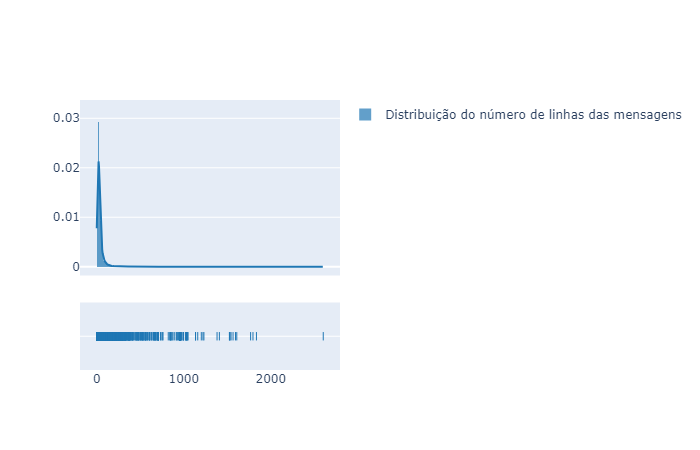

In [10]:
labels = ['Distribuição do número de linhas das mensagens'] 
fig = ff.create_distplot([df.lines], labels, bin_size=.99)
fig.show("png")

#### *Quantos emails únicos existem no dataframe?*

In [11]:
len(df['email_from'].unique()) # a função unique nos retorna todos os valores únicos

8610

#### *Qual a média de linhas do corpo da mensagem por classe?*

Percebemos que o assunto/notícia que possui mais linhas é relacionado a política. E o menos, é sobre componentes de hardware do mac.

In [12]:
df.groupby(['class']).mean().sort_values(['lines'], ascending=False)

,lines
class,
talk.politics.mideast,62.405000
talk.politics.misc,54.099000
comp.windows.x,45.586000
comp.os.ms-windows.misc,45.248000
soc.religion.christian,44.990973
sci.crypt,43.365000
alt.atheism,43.168000
talk.politics.guns,43.166000
talk.religion.misc,42.255000


#### *Vamos visualizar um gráfico de caixa para a quantidade de linhas?*
Existem muitos arquivos com quantidade de linhas acima da média.

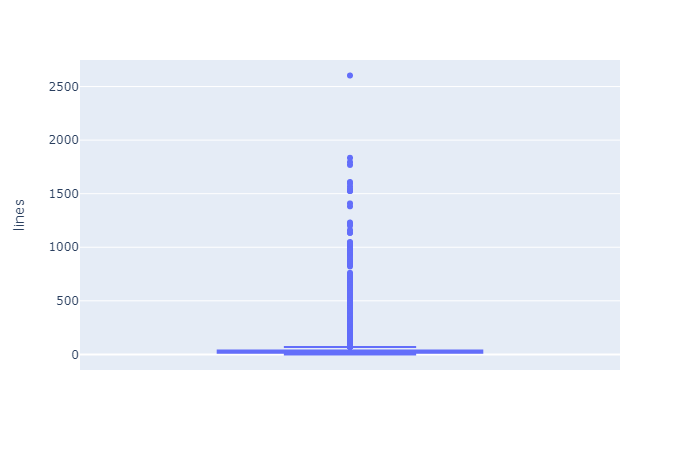

In [13]:
fig = px.box(df, y="lines")
fig.show("png")

### **Limpeza dos Dados**

Separando apenas a feature que vamos trabalhar, e a variável target.

In [14]:
pre_df = df[['message', 'class']]
pre_df.head()

,message,class
0,\nArchive-name: atheism/resources\nAlt-atheism...,alt.atheism
1,\nArchive-name: atheism/introduction\nAlt-athe...,alt.atheism
2,\nIn article <65974@mimsy.umd.edu>\nmangoe@cs....,alt.atheism
3,\ndmn@kepler.unh.edu (...until kings become ph...,alt.atheism
4,\nIn article <N4HY.93Apr5120934@harder.ccr-p.i...,alt.atheism


Selecionando apenas os dados que possuem ao menos um caracter

In [15]:
pre_df = pre_df.loc[~(pre_df['message'] == '')]
pre_df.shape

(19929, 2)

In [16]:
# Funcao para deixar todos os caracteres em caixa baixa
transform_to_lower = lambda s: s.lower()

# Funcao que remove todos os caracteres de tamanho = 1
remove_single_char = lambda s: re.sub(r'\s+\w{1}\s+', '', s)

# Filtros do gensim para pipeline de pre-processamento
# Remove as tags, numeros, pontuacoes, espacos, stopwords e char únicos
CUSTOM_FILTERS = [strip_tags,
                strip_numeric,
                strip_punctuation, 
                strip_multiple_whitespaces, 
                transform_to_lower,
                remove_stopwords,
                remove_single_char]

# Funcao para filtrar textos irrelevantes
def pipeline_preprocess(text):
    processed_words = preprocess_string(text, CUSTOM_FILTERS)
    return ' '.join(processed_words) # Transformo lista em uma única string

pre_df['message_clean'] = pre_df['message'].apply(pipeline_preprocess)
pre_df['message_clean'] = pre_df['message_clean'].apply(stem_text) # Realizo o stemming

Infelizmente, o pré-processamento do texto pode deixar alguns **efeitos colaterais**, como por exemplo deixar sem palavras restantes.

Podemos ter 3 estratégias:

* Remover a linha, porém em produção isso não seria legal.
* Imputar algum valor. Ex: [no_text]
* Se aplicar Word2Vec: use a média de todos os vetores.

Vamos optar pela segunda estratégia.

In [17]:
limpa_vazio = pre_df['message_clean'] == ''
print('{} registros/instâncias não possuem palavras restantes após a limpeza do texto.'.format(pre_df['message_clean'][limpa_vazio].count()))
pre_df['message_clean'].loc[limpa_vazio] = '[no_text]'

24 registros/instâncias não possuem palavras restantes após a limpeza do texto.


### **Separação dos Dados**
Dividimos nosso dataset afim de evitar vazamentos de dados, e também para avaliar nosso modelo treinado em um conjunto totalmente "desconhecido".

In [18]:
#20% para dados de teste e 80% para dados de treinamento
X_train, X_test, y_train, y_test = train_test_split(pre_df['message_clean'], pre_df['class'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15943,), (3986,), (15943,), (3986,))

### **Treinamento do Modelo**
Definimos uma pipeline que realiza a transformação para a representação dos textos com a técnica mais conhecida que é a *TF-IDF*, e depois treina o nosso modelo com os dados de treinamento.

In [19]:
text_clf = Pipeline([
     ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
     ('clf', LinearSVC(C=2.5, class_weight='balanced', random_state=0))
 ])

In [20]:
text_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf',
                 LinearSVC(C=2.5, class_weight='balanced', random_state=0))])

### **Avaliação do Modelo**
A **escolha da métrica** é uma fase importante e tem que se gastar um pouquinho de tempo para escolher a métrica certa. Pois um erro na escolha da métrica pode fazer o projeto ser mal sucedido. 

A **acurácia** é uma boa escolha, pois é fácil de se interpretar e o nosso problema está balanceado. O **F1 Score** foi escolhido como segunda métrica, para não depositarmos todas as nossas fichas na acurácia.

O nosso modelo consegue generalizar bem os dados. Temos uma acurácia e f1 score muito boa nos dados de teste. E o intervalo de score da nossa base de teste para o treinamento não é tão grande, e isso é um bom sinal.

Podemos observar que a classe **talk.religion.misc** possui um recall muito baixo. É preciso analisar com mais cuidado o que está acontecendo nessa classe, o por quê de não estar recuperando bem.

In [21]:
predicted = text_clf.predict(X_test)

print("DADOS DE TESTE")
print("Accuracy:", accuracy_score(y_test, predicted))
print("F1-Score:", f1_score(y_test, predicted, average='macro'))
print("DADOS DE TREINAMENTO")
print("Accuracy:", accuracy_score(y_train, text_clf.predict(X_train)))
print("F1-Score:", f1_score(y_train, text_clf.predict(X_train), average='macro'))

print(classification_report(y_test, predicted))

DADOS DE TESTE
Accuracy: 0.8785750125439037
F1-Score: 0.8740671309174379
DADOS DE TREINAMENTO
Accuracy: 0.9756633005080599
F1-Score: 0.9760598425643465
                          precision    recall  f1-score   support

             alt.atheism       0.74      0.73      0.73       177
           comp.graphics       0.76      0.84      0.79       177
 comp.os.ms-windows.misc       0.92      0.83      0.87       221
comp.sys.ibm.pc.hardware       0.79      0.83      0.81       204
   comp.sys.mac.hardware       0.93      0.88      0.91       205
          comp.windows.x       0.89      0.90      0.89       193
            misc.forsale       0.80      0.87      0.83       197
               rec.autos       0.92      0.91      0.91       213
         rec.motorcycles       0.98      0.95      0.96       217
      rec.sport.baseball       0.96      0.97      0.96       202
        rec.sport.hockey       0.97      0.99      0.98       204
               sci.crypt       0.94      0.96      0.95

Plotamos uma **curva de aprendizado** para visualizar melhor como está o desempenho do nosso modelo na medida em que jogamos mais dados.

Podemos enxergar que o score nos dados de teste não sobe muito a partir de 8000 instâncias. Isso nos leva a crer que, a quantidade de dados adicionada com essa mesma representação não vai nos ajudar muito. É preciso alterar ou a representação, ou modelo, enfim...

Também podemos observar um leve overfitting, seja por causa de algum ruido, mas esse 'leve' não invalida o nosso modelo.

**OBS**.: Esta função demora um pouco...

Aparece esse aviso porém não altera o nosso resultado final. É apenas porque utilizamos n_jobs = -1. `A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak`.

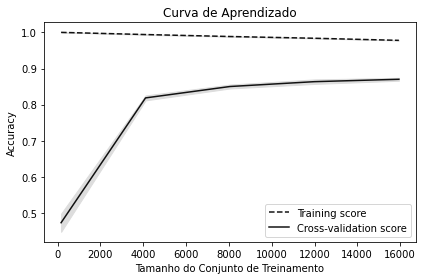

In [22]:
train_sizes, train_scores, test_scores = learning_curve(text_clf, 
                                                        pre_df['message_clean'], 
                                                        pre_df['class'],
                                                        cv=ShuffleSplit(n_splits=3, test_size=0.2, random_state=0),
                                                        scoring='accuracy',
                                                        n_jobs=-1, 
                                                        train_sizes=np.linspace(0.01, 1.0, 5))

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Curva de Aprendizado")
plt.xlabel("Tamanho do Conjunto de Treinamento"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### **Interpretação do Modelo**
É sempre bom analisar o que o nosso modelo aprendeu de fato. Existem casos em que é necessário **explicar** o por quê do modelo decidir tal classe/valor.

Há diversos tipos de abordagens para se interpretar o modelo. Seja **geral** (todos os exemplos) ou **local** (somente em um exemplo predito). Você pode utilizar de técnicas como os SHAP value ou analisar quais features o modelo considera mais importantes para decisão.

O SVM com kernel Linear nos dá os valores dos coeficientes (w) dos hiperplanos. Se realizarmos o produto escalar do vetor w com algum ponto, podemos dizer de qual lado ele está, se o resultado for positivo (pertence a classe positiva) ou negativo (pertence a classe negativa). 

Dessa forma, poderemos retirar algum valor de importância. Digamos que o SVM encontraria apenas um recurso útil para separar os dados, então o hiperplano seria ortogonal a esse eixo. Portanto, você poderia dizer que o tamanho absoluto do coeficiente em relação aos outros fornece uma indicação de quão importante o recurso foi para a separação.

In [23]:
def top_importance_feature(vectorizer, clf, class_labels, n_features=10):
    """Retorna as features com maiores valores de coeficientes, por classe."""
    feature_names = vectorizer.get_feature_names()
    importance_coefs = dict()
  
    for i, class_label in enumerate(class_labels):
        top_n = np.argsort(clf.coef_[i])[-n_features:]
        importance_coefs[class_label] = list(zip(sorted(clf.coef_[i])[-n_features:], [feature_names[j] for j in top_n]))
    return importance_coefs 

dict_importance = top_importance_feature(text_clf['tfidf'], text_clf['clf'], text_clf['clf'].classes_)

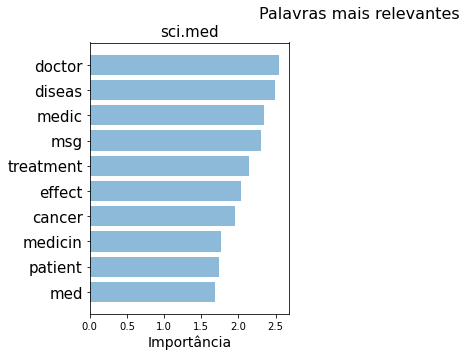

In [24]:
def plot_importance_feature(name_class, dict_features):
    """Método para plotar as features mais importantes, para apenas uma classe."""
    top_scores = [a[0] for a in dict_features[name_class]]
    top_words = [a[1] for a in dict_features[name_class]]
    y_pos = np.arange(len(top_words))

    fig = plt.figure(figsize=(10, 5))
  
    plt.subplot(121)
    plt.barh(y_pos, top_scores, align='center', alpha=0.5)
    plt.title(name_class, fontsize=15)
    plt.yticks(y_pos, top_words, fontsize=15)
    plt.suptitle('Palavras mais relevantes', fontsize=16)
    plt.xlabel('Importância', fontsize=14)

    plt.subplots_adjust(wspace=0.8)
    plt.show()

plot_importance_feature(text_clf['clf'].classes_[13], dict_importance)

O que se percebe, é que para cada classe há um contexto em que existem palavras/jargões que definem ou separam muito bem cada classe. Por isso a técnica TF-IDF funciona muito bem.

A classe que obteve pior desempenho como *talk.religion.misc* talvez esteja sofrendo por causa de outras classes com assuntos bastante ligados como *soc.religion.christian* e *alt.atheism*. Pode estar ligado também ao alto recall em soc.religion.christian.

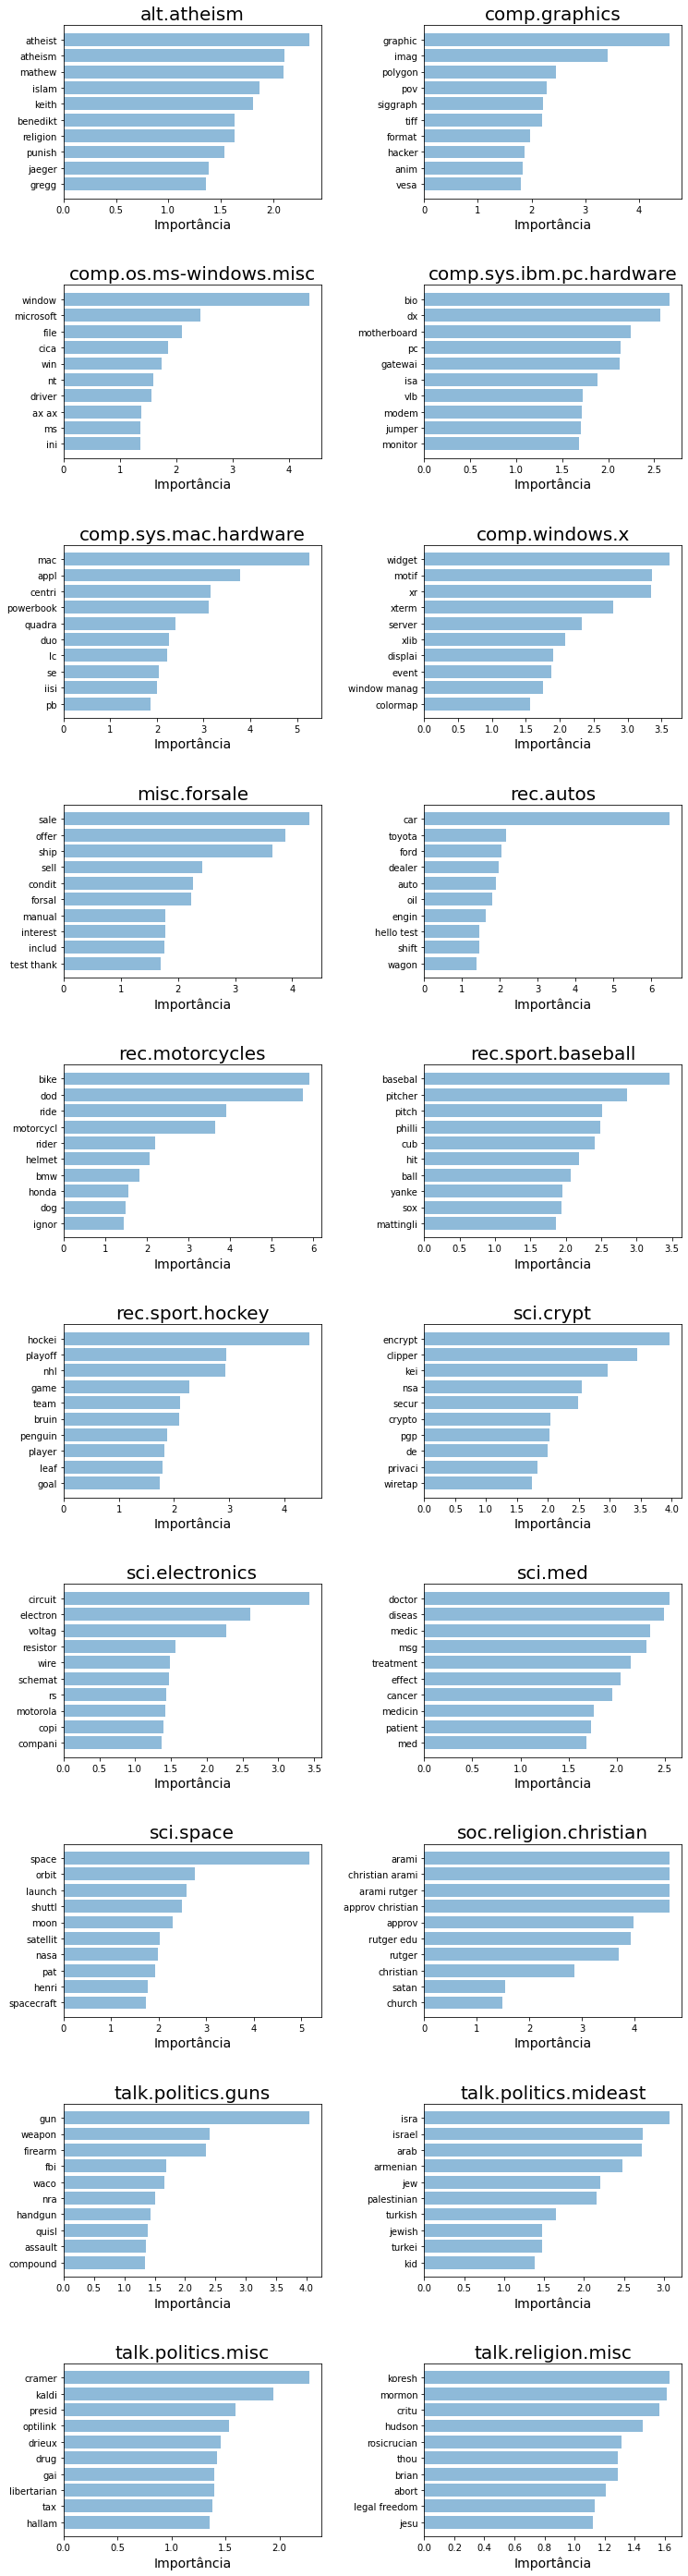

In [25]:
def plot_all_importance_feature(name_class, dict_features):
    """Método para plotar todas as features mais importantes, por classe"""
    fig, axs = plt.subplots(10,2, figsize=(12, 50), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.4)
    axs = axs.ravel()

    for i in range(len(name_class)):
        top_scores = [a[0] for a in dict_features[name_class[i]]]
        top_words = [a[1] for a in dict_features[name_class[i]]]
        y_pos = np.arange(len(top_words))

        axs[i].barh(y_pos, top_scores, align='center', alpha=0.5)
        axs[i].set_title(name_class[i], fontsize=20)
        axs[i].set_yticks(y_pos)
        axs[i].set_yticklabels(top_words)
        axs[i].set_xlabel('Importância', fontsize=14)

plot_all_importance_feature(text_clf['clf'].classes_, dict_importance)